In [16]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

In [17]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                        data["sub_experiment_path"] = seed_path
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    cfg_data["sub_experiment_path"] = seed_folder_path 
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            key = f"sub_exp_cfg_{key.strip()}"  # Add prefix
            variables[key] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [18]:
experiment_sub_dir = "2025Apr22-104437_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_experiment_path', 'seed', 'experiment_name'],
      dtype='object')

In [19]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_experiment_path,seed,experiment_name
0,training,200000,-44.901514,-13.910508,-29.635000,-29.789408,4.838108e+00,-6.772785,-4.736335,-6.153652,...,-1.764214e-01,-1.138245e-01,1.872504e-01,24374.0,48.0,0 days 00:02:15.510518,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
1,training,400000,-28.900803,-6.233432,-11.429765,-10.971698,2.626016e+00,-6.492985,-3.450930,-4.637021,...,-2.286411e-01,-1.555480e-01,2.488499e-01,25000.0,48.0,0 days 00:02:17.707912,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
2,training,600000,-18.820740,-5.144186,-9.361272,-9.163066,1.894236e+00,-6.318224,-3.096851,-4.299817,...,-2.119492e-01,-1.383740e-01,2.709721e-01,25000.0,48.0,0 days 00:02:29.182700,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
3,training,800000,-14.373797,-3.351172,-5.876890,-5.637523,1.388096e+00,-5.754669,-2.389827,-3.349275,...,-1.080763e-01,-1.177649e-02,2.431886e-01,25000.0,48.0,0 days 00:02:32.725122,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
4,training,1000000,-13.298136,-3.370870,-5.712231,-5.529706,1.158669e+00,-5.769119,-2.410670,-3.184756,...,-2.885145e-02,7.521364e-02,1.904588e-01,25000.0,56.0,0 days 00:02:35.202315,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,validation,3200000,-9.986887,-9.986887,-9.986887,-9.986887,0.000000e+00,-1.919509,-1.919509,-1.919509,...,4.805678e+10,4.828747e+10,1.714532e+09,NaN,NaN,0 days 00:00:00.633734,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
196,validation,3400000,-15.574341,-15.574341,-15.574341,-15.574341,1.776357e-15,-2.254386,-2.254386,-2.254386,...,4.566119e+10,4.575853e+10,1.392688e+09,NaN,NaN,0 days 00:00:00.425645,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
197,validation,3600000,-15.574341,-10.940786,-15.110985,-15.574341,1.390066e+00,-2.254386,-2.193455,-2.248293,...,5.093289e+10,5.045822e+10,2.845123e+09,NaN,NaN,0 days 00:00:00.447836,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
198,validation,3800000,-15.574341,-13.827181,-15.399625,-15.574341,5.241479e-01,-2.254386,-2.254053,-2.254353,...,5.556048e+10,5.547137e+10,2.458766e+09,NaN,NaN,0 days 00:00:00.403973,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...


In [20]:
# normalize rewards?

In [21]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_experiment_path,seed,experiment_name
20,validation,200000,-10.727393,-10.301113,-10.318875,-10.301113,8.518203e-02,-4.450740,-4.372419,-4.375683,...,-2.054827e-01,-1.287939e-01,2.311906e-01,NaN,NaN,0 days 00:00:00.402539,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
21,validation,400000,-5.514243,-5.514243,-5.514243,-5.514243,8.881784e-16,-3.393083,-3.393083,-3.393083,...,-1.992202e-01,-1.357827e-01,2.478327e-01,NaN,NaN,0 days 00:00:00.396521,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
22,validation,600000,-4.599340,-4.495743,-4.497815,-4.495743,1.450359e-02,-2.983877,-2.961241,-2.961694,...,-1.570835e-01,-8.837270e-02,2.549128e-01,NaN,NaN,0 days 00:00:00.403949,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
23,validation,800000,-10.219542,-9.831823,-10.180770,-10.219542,1.163158e-01,-2.597734,-2.593958,-2.594336,...,6.234890e-02,8.592138e-02,9.140651e-02,NaN,NaN,0 days 00:00:00.383367,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
24,validation,1000000,-9.671266,-8.996039,-9.603743,-9.671266,2.025680e-01,-2.573325,-2.572423,-2.573235,...,8.109440e-02,1.059804e-01,9.020333e-02,NaN,NaN,0 days 00:00:00.386471,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,validation,3200000,-9.986887,-9.986887,-9.986887,-9.986887,0.000000e+00,-1.919509,-1.919509,-1.919509,...,4.805678e+10,4.828747e+10,1.714532e+09,NaN,NaN,0 days 00:00:00.633734,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
196,validation,3400000,-15.574341,-15.574341,-15.574341,-15.574341,1.776357e-15,-2.254386,-2.254386,-2.254386,...,4.566119e+10,4.575853e+10,1.392688e+09,NaN,NaN,0 days 00:00:00.425645,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
197,validation,3600000,-15.574341,-10.940786,-15.110985,-15.574341,1.390066e+00,-2.254386,-2.193455,-2.248293,...,5.093289e+10,5.045822e+10,2.845123e+09,NaN,NaN,0 days 00:00:00.447836,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
198,validation,3800000,-15.574341,-13.827181,-15.399625,-15.574341,5.241479e-01,-2.254386,-2.254053,-2.254353,...,5.556048e+10,5.547137e+10,2.458766e+09,NaN,NaN,0 days 00:00:00.403973,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...


In [22]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_agent_params.args_.action_w_noise_amplitude    0.3
Name: 2, dtype: object
Best mean reward: -1.6423889599860673


In [23]:
averaged_results

,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,episode_rewards_mean,sub_experiment_path
0,0,-8.578342,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,0.1,-2.540361,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,0.3,-1.642389,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,0.6,-1.723823,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
4,0.9,-14.730300,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


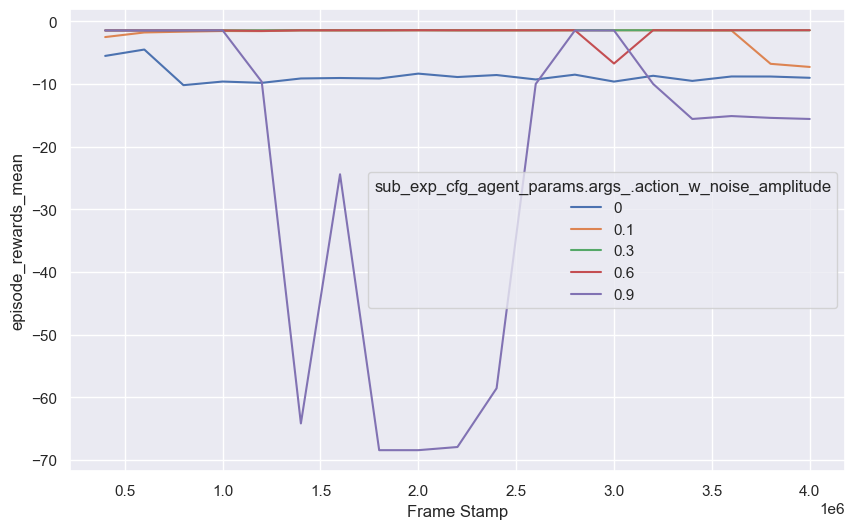

In [34]:
selected_metric = 'episode_rewards_mean'
hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

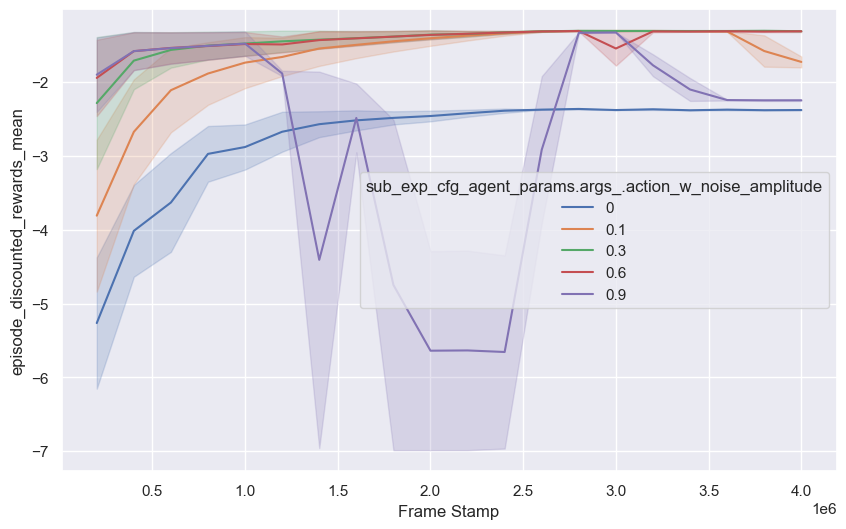

In [35]:

selected_metric = 'episode_discounted_rewards_mean'
hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue=hue_col)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [26]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude
39,validation,4000000,-9.006773,100.0,-2.371925,NaN,NaN,0 days 00:00:00.562229,0,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0
79,validation,4000000,-7.274530,100.0,-1.799755,NaN,NaN,0 days 00:00:00.419232,0,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.1
119,validation,4000000,-1.427907,6.0,-1.308171,NaN,NaN,0 days 00:00:00.516049,0,0002_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3
159,validation,4000000,-1.413925,6.0,-1.299674,NaN,NaN,0 days 00:00:00.453159,0,0003_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.6
199,validation,4000000,-15.574341,100.0,-2.254386,NaN,NaN,0 days 00:00:00.371501,0,0004_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.9


In [27]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0


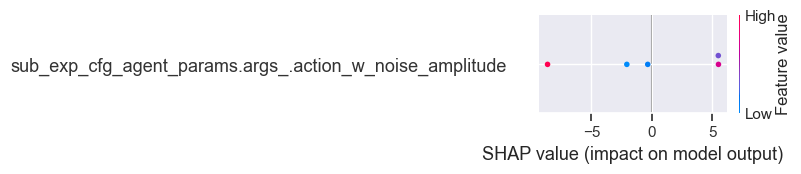

In [28]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [29]:
hyperparam_columns

['sub_exp_cfg_agent_params.args_.action_w_noise_amplitude']

In [30]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()


IndexError: list index out of range